## Zika Analysis: um estudo sobre os casos de Zika Vírus e Microcefalia no Brasil

<img src="lasdpc-logo.png" alt="Drawing"/>

In [19]:
'''
Distributed Systems and Concurrent Programming Laboratory (LaSDPC)
Institute of Mathematical and Computer Sciences
University of São Paulo
Authors: Vinícius Aires Barros
         Gabriel Tomiatti
         Ana Spengler
'''
import os, shutil, csv, io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spark_utils as spUtils
from math import sqrt
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mpl_toolkits.mplot3d import Axes3D
from pyspark.mllib.clustering import KMeans

### Read Dataset in Pandas

In [20]:
#Show Zika Table Content
input_path = 'dataset/lista_dados_sage_origin_headers.csv'
file_input_pd = pd.read_csv(input_path, delimiter=',')

#Show shape of data
file_input_pd.shape

(67243, 11)

## Data Dictionary
<img src="table-dic.png" width="500px"/>

In [21]:
#Show Table Content
file_input_pd.head(10)

,ibge,nu_semana,total_acumulado,total_investigacao,total_confirmado,total_descartado,total_obito_notificado,total_obito_investigado,total_obito_confirmado,total_obito_descartado,uf
0,120001,6,0,0,0,0,0,0,0,0,0
1,120005,6,0,0,0,0,0,0,0,0,0
2,120010,6,0,0,0,0,0,0,0,0,0
3,120010,37,1,1,0,0,0,0,0,0,0
4,120010,38,1,1,0,0,0,0,0,0,0
5,120010,39,1,1,0,0,0,0,0,0,0
6,120010,40,1,1,0,0,0,0,0,0,0
7,120010,41,1,1,0,0,0,0,0,0,0
8,120010,42,1,1,0,0,0,0,0,0,0
9,120010,43,1,1,0,0,0,0,0,0,0


### Read Zika Dataset in Apache Spark

In [22]:
#Reading the Input File
input_rdd = sc.textFile(input_path)

#Show the size of dataset
print("Size of dataset:", input_rdd.count(), "rows")

Size of dataset: 67244 rows


In [23]:
#Remove Header line of CSV
header = input_rdd.first()
input_rdd = input_rdd\
    .filter(lambda row : row != header)
print(header)

ibge,nu_semana,total_acumulado,total_investigacao,total_confirmado,total_descartado,total_obito_notificado,total_obito_investigado,total_obito_confirmado,total_obito_descartado,uf


In [24]:
#Converting CSV RDD data into RDD Array
zika_rdd = input_rdd\
    .map(lambda line: np.array([int(row) for row in line.split(',')]))

#Sorting Zika Cases Ascending by IBGE Number
zika_sorted_rdd = zika_rdd\
    .sortBy(lambda row : row[0])

#Get last consolidate data of Zika in 2016
cities_last_week_zika_rdd = zika_sorted_rdd\
    .filter(lambda row : row[1] == 50)

# Order by DESC Ten Cities of Zika Case

In [25]:
#Top 10 Zika Under Study Cases by Cities order by desc
top10_desc_zika_city_under_study = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : -row[3])

#Top 10 Zika Case by Cities order by desc
top10_desc_zika_city_cases = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : -row[4])

#Top 10 Zika Case Discarted by Cities order by desc
top10_desc_zika_city_discarted = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row : -row[5])
        
#Top 10 Zika Case of Deaths by Cities order by desc
top10_desc_zika_city_deaths = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: -row[6])

#Top 10 Case of Study Deaths by Cities order by desc
top10_desc_zika_city_death_study = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: -row[7])

#Top 10  Case of Confirmed Deaths by Cities order by desc
top10_desc_zika_city_death_confirmed = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: -row[8])

#Top 10 Case of Discarted Deaths by Cities order by desc
top10_desc_zika_city_death_discarded = cities_last_week_zika_rdd\
    .takeOrdered(10, key = lambda row: -row[9])

# K-Means Algorithm

In [57]:
def kmeans_error(point, clusters_rdd): 
    '''Method for evaluate the K-means Algorithm Error (SSSE)'''
    center = clusters_rdd.centers[clusters_rdd.predict(point)] 
    return sqrt(sum([x**2 for x in (point - center)]))

def get_best_k(k_arr):
    '''Method to evalutate the best k based in SSSE evaluation for the k-means algoritm'''
    k_err = 0
    k_best = 0
    maior = 0
    for index in range(1, len(k_arr)):
        if maior < (k_arr[index - 1] - k_arr[index]):
            maior = (k_arr[index - 1] - k_arr[index])
            k_best = ((index + 1) * 2)
            k_err = k_arr[index]
    return k_best, k_err     

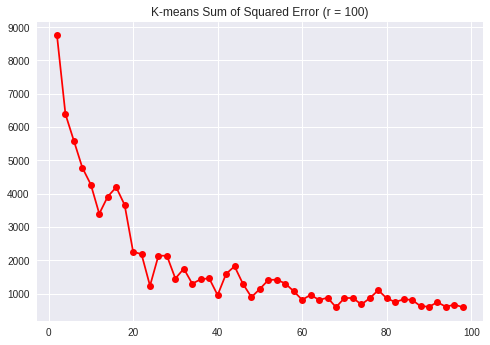

In [55]:
#Aplying PCA Algorithm for 2D ploting
pca_zika = cities_last_week_zika_rdd.collect()
pca = PCA(n_components=3)
pca_zika = pca.fit_transform(pca_zika)
kmeans_eval = []
start = 1
end = 100
k_samples = [x for x in range(start, end) if x % 2 == 0]

#Parallel K-Means Algorithm
pca_zika_rdd = sc.parallelize(pca_zika)

#For each k_samples calculte the K-Means SSE Error
for k in k_samples:
    clusters_rdd = KMeans.train(pca_zika_rdd, k, initializationMode='random')
    WSSSE = pca_zika_rdd\
            .map(lambda point: kmeans_error(point, clusters_rdd))\
            .reduce(lambda x, y: x + y)
    kmeans_eval.append(sqrt(WSSSE))
    
#Ploting K-Means Error Evaluation
plt.title("K-means Sum of Squared Error (r = {})".format(end))
plt.plot(k_samples, kmeans_eval, '-ro')
plt.savefig('/home/aires/git/zika-analysis/output/kmeans-wsse-err.pdf')
plt.show()

In [33]:
k_best, k_err = get_best_k(kmeans_eval)

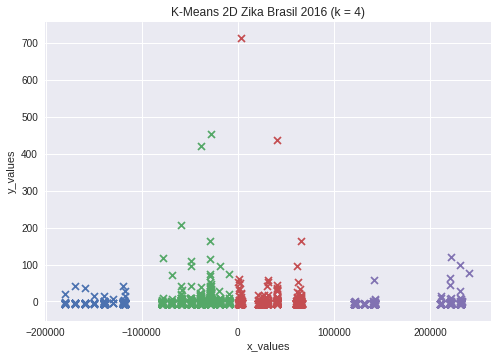

In [34]:
#Aplying PCA Algorithm for 2D ploting
pca_zika = cities_last_week_zika_rdd.collect()
pca = PCA(n_components=2)
pca_zika = pca.fit_transform(pca_zika)

#Parallel K-Means Algorithm
pca_zika_rdd = sc.parallelize(pca_zika)
clusters_rdd = KMeans.train(pca_zika_rdd, k_best, initializationMode='random')

#Group Cluster Data in a Python Dictionary
dic_cluster = defaultdict(list)
data = pca_zika_rdd.collect()
[dic_cluster[clusters_rdd.predict(item)].append(item) for item in data]
    
#Ploting K-Means Result in a Scatter Plot
for key in dic_cluster:
    x_arr = [dic_cluster[key][index][0] for index in range(0, len(dic_cluster[key]))]
    y_arr = [dic_cluster[key][index][1] for index in range(0, len(dic_cluster[key]))]
    plt.scatter(x_arr, y_arr, marker='x')

plt.title('K-Means 2D Zika Brasil 2016 (k = {})'.format(k_best))
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.savefig('/home/aires/git/zika-analysis/output/kmeans-zika2d-best.pdf')
plt.show()

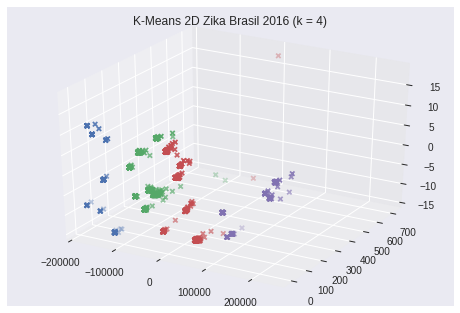

In [35]:
#Aplying PCA Algorithm for 3D ploting
pca_zika = cities_last_week_zika_rdd.collect()
pca = PCA(n_components=3)
pca_zika = pca.fit_transform(pca_zika)

#Parallel K-Means Algorithm
pca_zika_rdd = sc.parallelize(pca_zika)
clusters_rdd = KMeans.train(pca_zika_rdd, k_best, initializationMode='random')

#Group Cluster Data in a Python Dictionary
dic_cluster = defaultdict(list)
data = pca_zika_rdd.collect()
[dic_cluster[clusters_rdd.predict(item)].append(item) for item in data]

#Ploting K-Means Result in a Scatter Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key in dic_cluster:
    x_arr = [dic_cluster[key][index][0] for index in range(0, len(dic_cluster[key]))]
    y_arr = [dic_cluster[key][index][1] for index in range(0, len(dic_cluster[key]))]
    z_arr = [dic_cluster[key][index][2] for index in range(0, len(dic_cluster[key]))]
    ax.scatter(x_arr, y_arr, z_arr, marker='x')

plt.title('K-Means 2D Zika Brasil 2016 (k = {})'.format(k_best))
plt.savefig('/home/aires/git/zika-analysis/output/kmeans-zika3d-best.pdf')
plt.show()

# Numerical Analysis

In [36]:
#Sum Total of Cases by Region
total_death_region = {"Norte":0, "Nordeste":0, "Centro-Oeste":0, "Sudeste":0, "Sul":0}
total_death_by_state = []

br_state_region = {
    "Norte":[0, 2, 3, 13, 19, 21, 26],
    "Nordeste":[1, 4, 5, 9, 14, 15, 16, 20, 24],
    "Centro-Oeste":[6, 8, 11, 12],
    "Sudeste":[7, 10, 18, 25],
    "Sul":[17, 22, 23]
}

for i in range (0, 27):
    sum_value = cities_last_week_zika_rdd\
        .filter(lambda row : row[10] == i)\
        .map(lambda row : row[6]).sum()
    total_death_by_state.append(sum_value)
    
total_death_country = sum(total_death_by_state)

for key in br_state_region:
    sum_region = 0
    for index in br_state_region[key]:
        total_death_region[key] += total_death_by_state[index]

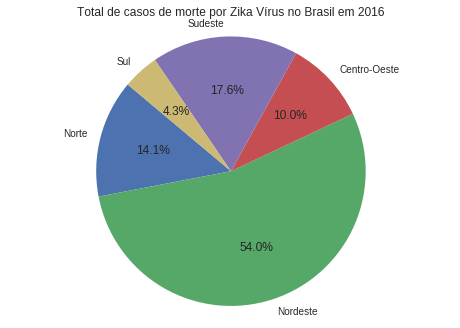

In [37]:
#Ploting Pie Chart
labels_pie = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]
sizes_pie = [total_death_region[key] for key in total_death_region]
plt.pie(sizes_pie, labels=labels_pie, autopct='%1.1f%%', startangle=140)
plt.title("Total de casos de morte por Zika Vírus no Brasil em 2016")
plt.axis('equal')

plt.savefig('/home/aires/git/zika-analysis/output/brazil-zika-pie.pdf')
plt.show()

In [38]:
total_death_region

{'Centro-Oeste': 55, 'Nordeste': 298, 'Norte': 78, 'Sudeste': 97, 'Sul': 24}

# Ten Cities Zika Cases

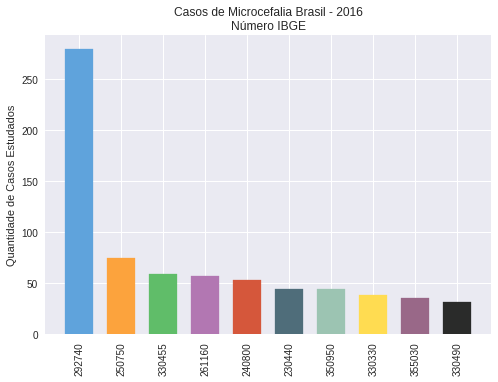

In [39]:
#Top 10 Zika Under Study Cases by Cities order by desc
y_zika = [x[3] for x in top10_desc_zika_city_under_study]
labels = [x[0] for x in top10_desc_zika_city_under_study]
colors = ['#5FA3DC', '#FCA33D', '#60BD69', '#B277B2', '#D5573B', '#4F6D7A', '#9CC4B2', '#FFDC51', '#996888', '#2A2B2A']

N = len(y_zika)
x = range(N)
width = (1/1.5)

#plt.xlabel('Número IBGE')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Quantidade de Casos Estudados')
plt.title('Casos de Microcefalia Brasil - 2016\nNúmero IBGE')

m_plot = plt.bar(x, y_zika, width=width)
[m_plot[index].set_color(color) for index, color in enumerate(colors)]
plt.savefig('/home/aires/git/zika-analysis/output/top10_desc_zika_city_under_study.pdf')
plt.show()

In [40]:
y_zika

[279, 75, 59, 57, 53, 44, 44, 38, 35, 31]

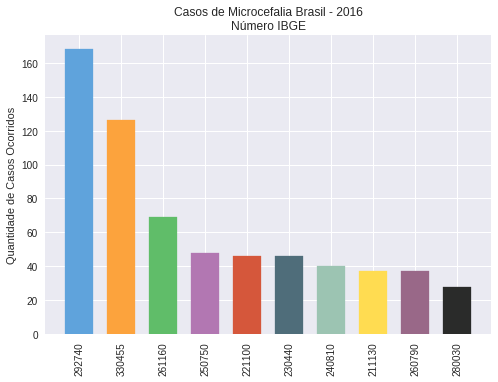

In [41]:
#Top 10 Zika Case by Cities order by desc
y_zika = [x[4] for x in top10_desc_zika_city_cases]
labels = [x[0] for x in top10_desc_zika_city_cases]

N = len(y_zika)
x = range(N)
width = (1/1.5)

#plt.xlabel('Número IBGE')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Quantidade de Casos Ocorridos')
plt.title('Casos de Microcefalia Brasil - 2016\nNúmero IBGE')

m_plot = plt.bar(x, y_zika, width)
[m_plot[index].set_color(color) for index, color in enumerate(colors)]
plt.savefig('/home/aires/git/zika-analysis/output/top10_desc_zika_city_cases.pdf')
plt.show()

In [42]:
y_zika

[168, 126, 69, 48, 46, 46, 40, 37, 37, 28]

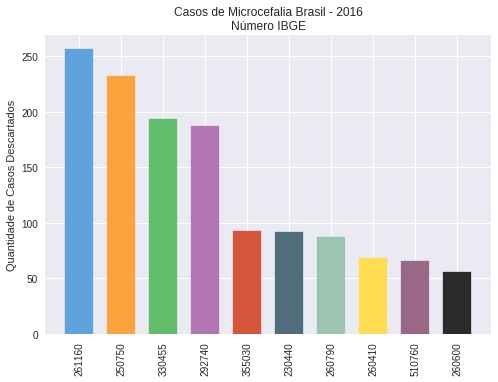

In [43]:
#Top 10 Zika Case Discarted by Cities order by desc
y_zika = [x[5] for x in top10_desc_zika_city_discarted]
labels = [x[0] for x in top10_desc_zika_city_discarted]

N = len(y_zika)
x = range(N)
width = (1/1.5)

#plt.xlabel('Número IBGE')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Quantidade de Casos Descartados')
plt.title('Casos de Microcefalia Brasil - 2016\nNúmero IBGE')

m_plot = plt.bar(x, y_zika, width=width)
[m_plot[index].set_color(color) for index, color in enumerate(colors)]
plt.savefig('/home/aires/git/zika-analysis/output/top10_desc_zika_city_discarted.pdf')
plt.show()

In [44]:
y_zika

[256, 232, 193, 187, 93, 92, 87, 68, 66, 56]

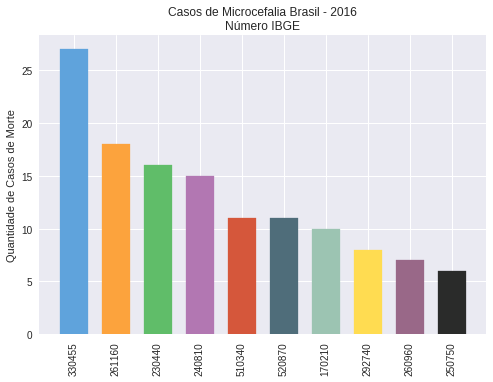

In [45]:
#Top 10 Zika Case of Deaths by Cities order by desc
y_zika = [x[6] for x in top10_desc_zika_city_deaths]
labels = [x[0] for x in top10_desc_zika_city_deaths]

N = len(y_zika)
x = range(N)
width = (1/1.5)

#plt.xlabel('Número IBGE')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Quantidade de Casos de Morte')
plt.title('Casos de Microcefalia Brasil - 2016\nNúmero IBGE')

m_plot = plt.bar(x, y_zika, width=width)
[m_plot[index].set_color(color) for index, color in enumerate(colors)]
plt.savefig('/home/aires/git/zika-analysis/output/top10_desc_zika_city_deaths.pdf')
plt.show()

In [46]:
y_zika

[27, 18, 16, 15, 11, 11, 10, 8, 7, 6]

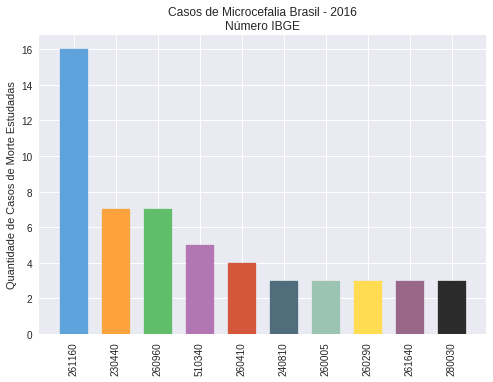

In [47]:
#Top 10 Case of Study Deaths by Cities order by desc
y_zika = [x[7] for x in top10_desc_zika_city_death_study]
labels = [x[0] for x in top10_desc_zika_city_death_study]

N = len(y_zika)
x = range(N)
width = (1/1.5)

#plt.xlabel('Número IBGE')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Quantidade de Casos de Morte Estudadas')
plt.title('Casos de Microcefalia Brasil - 2016\nNúmero IBGE')

m_plot = plt.bar(x, y_zika, width=width)
[m_plot[index].set_color(color) for index, color in enumerate(colors)]
plt.savefig('/home/aires/git/zika-analysis/output/top10_desc_zika_city_death_study.pdf')
plt.show()

In [48]:
y_zika

[16, 7, 7, 5, 4, 3, 3, 3, 3, 3]

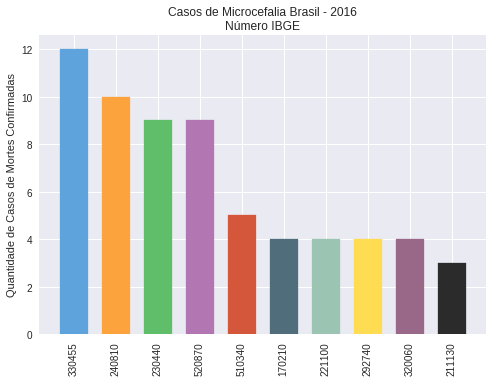

In [49]:
#Top 10  Case of Confirmed Deaths by Cities order by desc
y_zika = [x[8] for x in top10_desc_zika_city_death_confirmed]
labels = [x[0] for x in top10_desc_zika_city_death_confirmed]

N = len(y_zika)
x = range(N)
width = (1/1.5)

#plt.xlabel('Número IBGE')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Quantidade de Casos de Mortes Confirmadas')
plt.title('Casos de Microcefalia Brasil - 2016\nNúmero IBGE')

m_plot = plt.bar(x, y_zika, width=width)
[m_plot[index].set_color(color) for index, color in enumerate(colors)]
plt.savefig('/home/aires/git/zika-analysis/output/top10_desc_zika_city_death_confirmed.pdf')
plt.show()

In [50]:
y_zika

[12, 10, 9, 9, 5, 4, 4, 4, 4, 3]

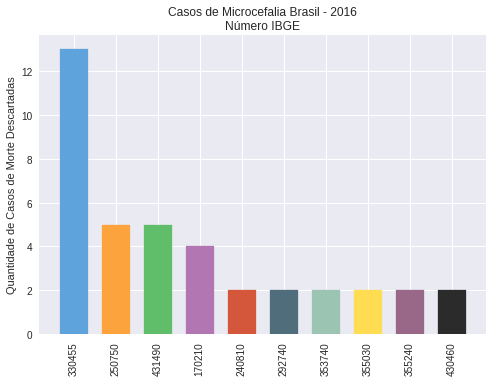

In [51]:
#Top 10  Case of Confirmed Deaths by Cities order by desc
y_zika = [x[9] for x in top10_desc_zika_city_death_discarded]
labels = [x[0] for x in top10_desc_zika_city_death_discarded]

N = len(y_zika)
x = range(N)
width = (1/1.5)

#plt.xlabel('Número IBGE')
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Quantidade de Casos de Morte Descartadas')
plt.title('Casos de Microcefalia Brasil - 2016\nNúmero IBGE')

m_plot = plt.bar(x, y_zika, width=width)
[m_plot[index].set_color(color) for index, color in enumerate(colors)]
plt.savefig('/home/aires/git/zika-analysis/output/top10_desc_zika_city_death_discarded.pdf')
plt.show()

In [52]:
y_zika

[13, 5, 5, 4, 2, 2, 2, 2, 2, 2]